In [87]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

In [88]:
df = pd.read_csv("datasets/heart_disease_uci.csv")
df.drop(columns=["id", "dataset"], inplace=True)

In [89]:
categorial_columns = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
cont_columns = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca"]

In [90]:
df[categorial_columns] = df[categorial_columns].apply(LabelEncoder().fit_transform)
df[categorial_columns] = MinMaxScaler().fit_transform(df[categorial_columns])

df[cont_columns] = MinMaxScaler().fit_transform(df[cont_columns])
df = df.fillna(df.mean())
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,0.714286,1.0,1.000000,0.725000,0.386401,0.5,0.000000,0.633803,0.0,0.556818,0.000000,0.000000,0.000000,0
1,0.795918,1.0,0.000000,0.800000,0.474295,0.0,0.000000,0.338028,0.5,0.465909,0.333333,1.000000,0.333333,2
2,0.795918,1.0,0.000000,0.600000,0.379768,0.0,0.000000,0.485915,0.5,0.590909,0.333333,0.666667,0.666667,1
3,0.183673,1.0,0.666667,0.650000,0.414594,0.0,0.333333,0.894366,0.0,0.693182,0.000000,0.000000,0.333333,0
4,0.265306,0.0,0.333333,0.650000,0.338308,0.0,0.000000,0.788732,0.0,0.454545,0.666667,0.000000,0.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.530612,0.0,0.000000,0.635000,0.552239,0.5,0.666667,0.661972,0.0,0.295455,1.000000,0.225458,1.000000,1
916,0.693878,1.0,1.000000,0.660662,0.230514,0.0,0.666667,0.546096,1.0,0.395317,1.000000,0.225458,1.000000,0
917,0.551020,1.0,0.000000,0.610000,0.369818,0.5,0.666667,0.281690,0.0,0.295455,1.000000,0.225458,0.000000,2
918,0.612245,1.0,0.000000,0.660662,0.638474,0.5,0.000000,0.546096,1.0,0.395317,1.000000,0.225458,1.000000,0


In [91]:
class HeartDiseaseDataset(Dataset):
    def __init__(self, df):
        self.y = torch.tensor(df["num"].values, dtype=torch.float)
        self.x = torch.tensor(df.drop(columns="num").values, dtype=torch.float)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]

In [92]:
dataset = HeartDiseaseDataset(df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
len(dataset)

920

In [93]:
class MixedTypeClusteringModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(13, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 7),
            torch.nn.ReLU(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(7, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 13),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


epochs = 20
lr = 0.001

model = MixedTypeClusteringModel()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    loss = 0

    for x, _ in dataloader:
        optimizer.zero_grad()
        outputs = model(x)
        train_loss = criterion(outputs,  x)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()

    loss = loss / len(dataloader)
    print("epoch: {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch: 1/20, loss = 0.077283
epoch: 2/20, loss = 0.061152
epoch: 3/20, loss = 0.049528
epoch: 4/20, loss = 0.039397
epoch: 5/20, loss = 0.033528
epoch: 6/20, loss = 0.028650
epoch: 7/20, loss = 0.026419
epoch: 8/20, loss = 0.024691
epoch: 9/20, loss = 0.022945
epoch: 10/20, loss = 0.021628
epoch: 11/20, loss = 0.020698
epoch: 12/20, loss = 0.020151
epoch: 13/20, loss = 0.019774
epoch: 14/20, loss = 0.019476
epoch: 15/20, loss = 0.019326
epoch: 16/20, loss = 0.019090
epoch: 17/20, loss = 0.018922
epoch: 18/20, loss = 0.018796
epoch: 19/20, loss = 0.018635
epoch: 20/20, loss = 0.018423


In [94]:
features = model.encoder(torch.tensor(df.drop(columns="num").values, dtype=torch.float)).detach().numpy()
features

array([[1.1192076 , 0.        , 0.10157049, ..., 0.41655818, 1.3445488 ,
        0.        ],
       [1.5682703 , 0.        , 0.87494195, ..., 0.        , 2.9753463 ,
        3.1484733 ],
       [1.9404223 , 0.        , 1.3617351 , ..., 0.        , 2.920523  ,
        4.0026474 ],
       ...,
       [2.5459037 , 0.        , 2.161465  , ..., 0.        , 1.7966133 ,
        2.7270598 ],
       [3.1567469 , 0.        , 1.7690308 , ..., 0.        , 2.023344  ,
        5.6846905 ],
       [3.8693018 , 0.        , 2.2724218 , ..., 0.05734738, 2.405736  ,
        4.5022626 ]], dtype=float32)

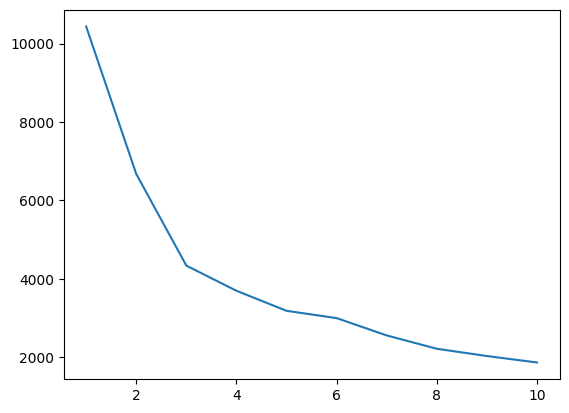

In [95]:
results = list()
k_cand = range(1, 11)

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(features)
    results.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(k_cand, results)